In [1]:
import torchaudio
root_path = '/kaggle/input/librispeech-clean'

In [2]:
train_dataset = torchaudio.datasets.LIBRISPEECH(root_path, url="train-clean-100", download=False)
test_dataset = torchaudio.datasets.LIBRISPEECH(root_path, url="test-clean", download=False)

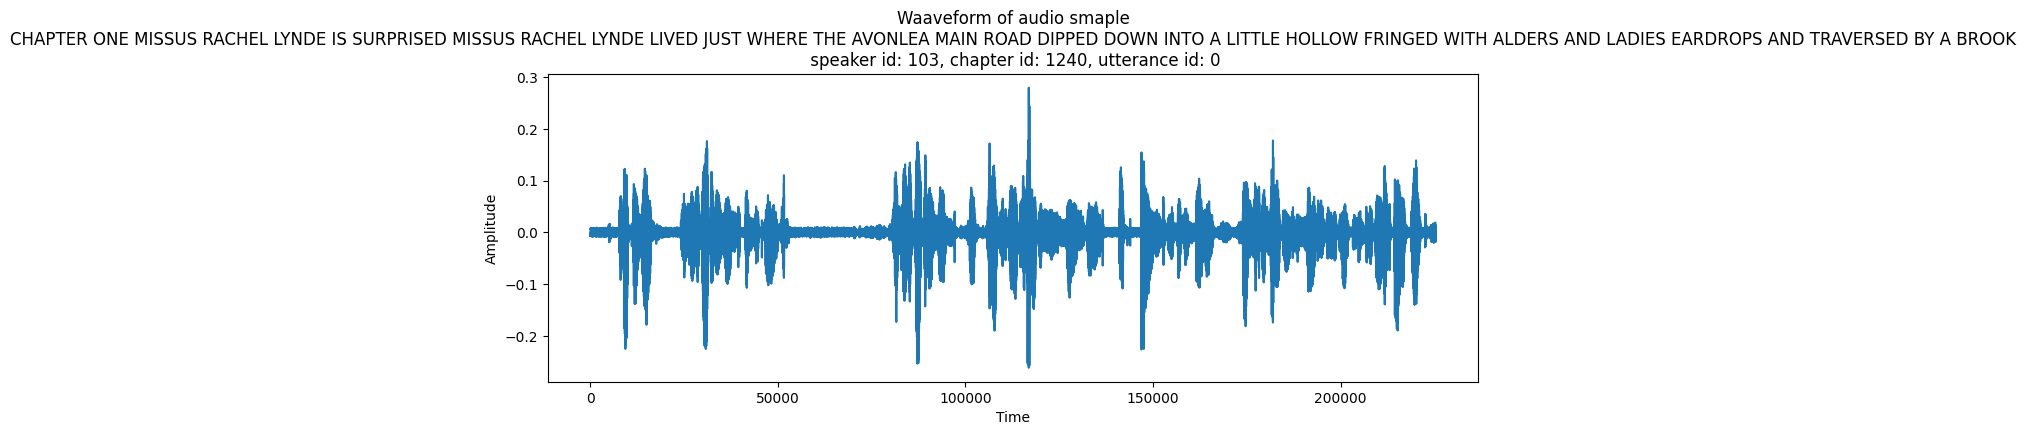

In [3]:
# Visulalize wavefrom
import matplotlib.pyplot as plt
waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = train_dataset[0]
# plot the waveform
plt.figure(figsize =(12, 4))
plt.plot(waveform.t().numpy())
plt.title(f"Waaveform of audio smaple\n{utterance}\n speaker id: {speaker_id}, chapter id: {chapter_id}, utterance id: {utterance_id}")
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
import IPython.display as ipd
ipd.Audio(waveform.numpy(), rate=sample_rate)

# Ars Metrics

In [ ]:
import numpy as np
def levenshtein_distance(ref, hyp):
    """Calculate the Levenshtien distance between two sequences"""
    m, n = len(ref), len(hyp)
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m
    
    if m < n :
        ref, hyp = hyp , ref
        m , n = n, m
        
    previous_row = range(n + 1)
    for i, c1 in enumerate(ref):
        current_row = [ i + 1]
        for j , c2 in enumerate(hyp):
            insertions = previous_row[ j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
            
        previous_row = current_row
    return previous_row[-1]

def normalize_text(text, ignore_case = False, remove_space = False):
    """Normalize text based on the specified conditions."""
    if ignore_case:
        text = text.lower()
    if remove_space:
        text = ''.join(text.split())
    return text

def calculate_errors(reference, hypothesis, ignore_case=False, remove_space=False, delimiter=None):
    """Calculates edit distance and length/reference length based on the mode (word or char level)."""
    reference = normalize_text(reference, ignore_case, remove_space)
    hypothesis = normalize_text(hypothesis, ignore_case, remove_space)

    if delimiter:
        reference = reference.split(delimiter)
        hypothesis = hypothesis.split(delimiter)

    edit_distance = levenshtein_distance(reference, hypothesis)
    ref_len = len(reference)

    return float(edit_distance), ref_len

def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Calculates word error rate."""
    edit_distance, ref_len = calculate_errors(reference, hypothesis, ignore_case, False, delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    return edit_distance / ref_len

def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    """Calculates character error rate."""
    edit_distance, ref_len = calculate_errors(reference, hypothesis, ignore_case, remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    return edit_distance / ref_len
            

In [6]:
import os
print(os.environ.get('CUDA_VISIBLE_DEVICES'))

None


In [7]:
cer('azizul', 'aziz')

0.3333333333333333

In [8]:
reference = 'Hello My Name is Hakim'
hypothesis = 'Hello My Neim is Hakim'

# Calculate cer
cer_result = cer(reference, hypothesis)
print(f"CER: {cer_result}")

# calculate WER
wer_result = wer(reference, hypothesis)
print(f"WER: {wer_result}")

CER: 0.13636363636363635
WER: 0.2


# Data Preparation

Text Transformation

In [9]:
import string
from itertools import dropwhile

class TextTransform:
    """Maps characters to integers and vice verse, using the string module for cahracter definitions"""
    
    def __init__(self):
        # Including additional characters manually and using string.ascii_lowercase for latters
        additional_chars = ["''", '<SPACE>']
        all_chars = additional_chars + list(string.ascii_lowercase)
        
        # Generatring char_map with enumeration, starting indices from 0
        self.char_map = {char: i for i, char in enumerate(all_chars)}
        # Inverting char_map to crate index_map
        self.index_map = {index: char for char, index in self.char_map.items()}
        self.index_map[self.char_map['<SPACE>']] = ' ' 
        
    def text_to_int(self, text):
        '''Converts text to an interger sequences using a character map'''
        return [self.char_map.get(c, self.char_map['<SPACE>']) for c in text.lower()]
    
    def int_to_text(self, labels):
        '''converts integer labels to a text sequence using a character map'''
        return ''.join(self.index_map[i] for i in labels).replace('<SPACE>', ' ')
    
    def int_to_text_remove_pad(self, int_sequence):
        # Remove trailing zeros which are used for padding
        # This is done by reversing the list, using itertools.dropwhile to drop the zeros,
        # and then reversing the list back to the original order
        from itertools import dropwhile

        # Reverse, remove zeros from the end (now start), and reverse back
        text_sequence = list(dropwhile(lambda x: x == 0, reversed(int_sequence)))[::-1]

        # Convert the non-padded sequence to text
        text = ''.join(self.index_map[i] for i in text_sequence).replace('<SPACE>', ' ')
        return text
    
    
# Example Usage 
text_transform = TextTransform()
test_text = 'This is Hakim'
test_ints = text_transform.text_to_int(test_text)
recovered_text = text_transform.int_to_text(test_ints)

print(f"original: {test_text}")
print(f"Converted to Int : {test_ints}")
print(f"Recoverd text: {recovered_text}")

original: This is Hakim
Converted to Int : [21, 9, 10, 20, 1, 10, 20, 1, 9, 2, 12, 10, 14]
Recoverd text: this is hakim


In [10]:
test_int = [21, 9, 10, 20, 1, 10, 20, 1, 9, 2, 12, 10, 14]
print('star: ' + text_transform.int_to_text_remove_pad(test_int) + "|end")

star: this is hakim|end


# How to pad batches

In [11]:
import torch
import torch.nn as nn

text_transform = TextTransform()

texts = ["Hello world", "My name is Hakim"]
labels = [torch.Tensor(text_transform.text_to_int(text)) for text in texts]
labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)
labels

tensor([[ 9.,  6., 13., 13., 16.,  1., 24., 16., 19., 13.,  5.,  0.,  0.,  0.,
          0.,  0.],
        [14., 26.,  1., 15.,  2., 14.,  6.,  1., 10., 20.,  1.,  9.,  2., 12.,
         10., 14.]])

# Convert Audio data

In [12]:
train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate = 16000, n_mels = 128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
    torchaudio.transforms.TimeMasking(time_mask_param=100)
)

valid_audio_transforms = torchaudio.transforms.MelSpectrogram()

waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = train_dataset[0]
spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
spec.shape

/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


torch.Size([1127, 128])

# convert specs of different sizes to batches

In [13]:
spectrograms = []
for waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id in [train_dataset[0], train_dataset[1]]:
    spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
    spectrograms.append(spec)
spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
spectrograms.size()

torch.Size([2, 1, 128, 1276])

# Full Data Loading

In [14]:
import torch
import torch.nn as nn

def data_processing(data, data_type = 'train'):
    if data_type not in ['train', 'valid']:
        raise ValueError("data_type should be either 'trian' or 'valid.'")
        
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    
    audio_transforms = train_audio_transforms if data_type == 'train' else valid_audio_transforms
    
    for (waveform, _, utterance, _, _, _) in data:
        spec = audio_transforms(waveform).squeeze(0).transpose(0, 1)
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0] // 2)
        label_lengths.append(len(label))
        
    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first = True).unsqueeze(1).transpose(2,3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first = True)
    return spectrograms, labels, input_lengths, label_lengths

In [15]:
import torch.utils.data as data

pipeline_params = {
    'batch_size': 10,
    'epochs': 1,
    'learning_rate': 5e-4,
    'n_cnn_layers': 3, 
    'n_rnn_layers':5,
    'rnn_dim': 512,
    'n_class': 29,
    'n_feats':  128,
    'stride': 2,
    'dropout': 0.1
}

kwargs = {'num_workers':1, 'pin_memory': True}
train_loader = data.DataLoader(dataset = train_dataset,
                              batch_size = pipeline_params['batch_size'],
                              shuffle = True,
                              collate_fn = lambda x: data_processing(x, 'train'),
                              **kwargs)
test_loader = data.DataLoader(dataset = test_dataset,
                             batch_size = pipeline_params['batch_size'],
                             shuffle = True,
                             collate_fn=lambda x: data_processing(x, 'valid'),
                             **kwargs)

In [16]:
use_cuda = torch.cuda.is_available()
print(use_cuda)
device = torch.device('cuda' if use_cuda else 'cpu')

print('Picked Device', device)

True
Picked Device cuda


# Modeling

In [17]:
use_cuda = torch.cuda.is_available()
print(use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")

print("Picked device:", device)


class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time)

class ResidualCNN(nn.Module):
    """
    Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf except with layer norm instead of batch norm
    """
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)

class BidirectionalGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x

True
Picked device: cuda


# Speech Recognition Model

In [18]:
class SpeechRecognitionModel(nn.Module):
    """Speech Recognition Model Inspired by DeepSpeech 2"""

    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats)
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

model = SpeechRecognitionModel(pipeline_params['n_cnn_layers'], pipeline_params['n_rnn_layers'], pipeline_params['rnn_dim'], pipeline_params['n_class'], pipeline_params['n_feats'], pipeline_params['stride'], pipeline_params['dropout']).to(device)

In [19]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

optimizer = optim.AdamW(model.parameters(), pipeline_params["learning_rate"])

criterion = nn.CTCLoss(blank=28).to(device)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=pipeline_params["learning_rate"],
                                        steps_per_epoch=int(len(train_loader)),
                                        epochs=pipeline_params["epochs"],
                                        anneal_strategy="linear")

data_len = len(train_loader.dataset)
logging_idx = 0
logging_freq = 100
for epoch in range(pipeline_params["epochs"]):
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{pipeline_params['epochs']}", unit="batches")
    for batch_idx, _data in progress_bar:
        spectrograms, labels, input_lengths, label_lengths = _data
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(spectrograms)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1)

        loss = criterion(output, labels, input_lengths, label_lengths)
        loss.backward()

        optimizer.step()
        scheduler.step()
        if logging_idx % logging_freq == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, 
                batch_idx * len(spectrograms), 
                data_len, 100. * batch_idx / len(train_loader), 
                loss.item()
            ))
        logging_idx += 1
        progress_bar.set_postfix({'loss': loss.item()})


Epoch 1/1:   0%|          | 1/2854 [00:01<1:18:18,  1.65s/batches, loss=7.08]

Train Epoch: 0 [0/28539 (0%)]	Loss: 7.079684


Epoch 1/1:   4%|▎         | 101/2854 [00:30<13:18,  3.45batches/s, loss=2.87]

Train Epoch: 0 [1000/28539 (4%)]	Loss: 2.865905


Epoch 1/1:   7%|▋         | 201/2854 [01:00<12:58,  3.41batches/s, loss=2.88]

Train Epoch: 0 [2000/28539 (7%)]	Loss: 2.879524


Epoch 1/1:  11%|█         | 301/2854 [01:29<12:13,  3.48batches/s, loss=2.85]

Train Epoch: 0 [3000/28539 (11%)]	Loss: 2.852502


Epoch 1/1:  14%|█▍        | 401/2854 [01:58<11:57,  3.42batches/s, loss=2.84]

Train Epoch: 0 [4000/28539 (14%)]	Loss: 2.835337


Epoch 1/1:  18%|█▊        | 501/2854 [02:27<11:15,  3.48batches/s, loss=2.81]

Train Epoch: 0 [5000/28539 (18%)]	Loss: 2.813238


Epoch 1/1:  21%|██        | 601/2854 [02:56<10:41,  3.51batches/s, loss=2.83]

Train Epoch: 0 [6000/28539 (21%)]	Loss: 2.825632


Epoch 1/1:  25%|██▍       | 701/2854 [03:25<10:24,  3.45batches/s, loss=2.86]

Train Epoch: 0 [7000/28539 (25%)]	Loss: 2.863424


Epoch 1/1:  28%|██▊       | 801/2854 [03:54<10:11,  3.36batches/s, loss=2.86]

Train Epoch: 0 [8000/28539 (28%)]	Loss: 2.856656


Epoch 1/1:  32%|███▏      | 901/2854 [04:24<09:21,  3.48batches/s, loss=2.85]

Train Epoch: 0 [9000/28539 (32%)]	Loss: 2.853321


Epoch 1/1:  35%|███▌      | 1001/2854 [04:53<08:56,  3.46batches/s, loss=2.82]

Train Epoch: 0 [10000/28539 (35%)]	Loss: 2.818507


Epoch 1/1:  39%|███▊      | 1101/2854 [05:22<08:34,  3.41batches/s, loss=2.73]

Train Epoch: 0 [11000/28539 (39%)]	Loss: 2.733927


Epoch 1/1:  42%|████▏     | 1201/2854 [05:51<08:07,  3.39batches/s, loss=2.49]

Train Epoch: 0 [12000/28539 (42%)]	Loss: 2.492338


Epoch 1/1:  46%|████▌     | 1301/2854 [06:21<07:34,  3.42batches/s, loss=2.41]

Train Epoch: 0 [13000/28539 (46%)]	Loss: 2.412332


Epoch 1/1:  49%|████▉     | 1401/2854 [06:50<07:08,  3.39batches/s, loss=2.13]

Train Epoch: 0 [14000/28539 (49%)]	Loss: 2.128724


Epoch 1/1:  53%|█████▎    | 1501/2854 [07:19<06:45,  3.34batches/s, loss=2.01]

Train Epoch: 0 [15000/28539 (53%)]	Loss: 2.014662


Epoch 1/1:  56%|█████▌    | 1601/2854 [07:48<06:11,  3.37batches/s, loss=1.9] 

Train Epoch: 0 [16000/28539 (56%)]	Loss: 1.895441


Epoch 1/1:  60%|█████▉    | 1701/2854 [08:18<05:44,  3.35batches/s, loss=1.84]

Train Epoch: 0 [17000/28539 (60%)]	Loss: 1.843801


Epoch 1/1:  63%|██████▎   | 1801/2854 [08:47<05:10,  3.39batches/s, loss=1.83]

Train Epoch: 0 [18000/28539 (63%)]	Loss: 1.825641


Epoch 1/1:  67%|██████▋   | 1901/2854 [09:16<04:39,  3.41batches/s, loss=1.86]

Train Epoch: 0 [19000/28539 (67%)]	Loss: 1.864212


Epoch 1/1:  70%|███████   | 2001/2854 [09:45<04:11,  3.39batches/s, loss=1.62]

Train Epoch: 0 [20000/28539 (70%)]	Loss: 1.618007


Epoch 1/1:  74%|███████▎  | 2101/2854 [10:15<03:43,  3.37batches/s, loss=1.79]

Train Epoch: 0 [21000/28539 (74%)]	Loss: 1.787846


Epoch 1/1:  77%|███████▋  | 2201/2854 [10:44<03:09,  3.44batches/s, loss=1.66]

Train Epoch: 0 [22000/28539 (77%)]	Loss: 1.658571


Epoch 1/1:  81%|████████  | 2301/2854 [11:13<02:41,  3.41batches/s, loss=1.47]

Train Epoch: 0 [23000/28539 (81%)]	Loss: 1.466619


Epoch 1/1:  84%|████████▍ | 2401/2854 [11:42<02:14,  3.36batches/s, loss=1.52]

Train Epoch: 0 [24000/28539 (84%)]	Loss: 1.520204


Epoch 1/1:  88%|████████▊ | 2501/2854 [12:11<01:44,  3.39batches/s, loss=1.52]

Train Epoch: 0 [25000/28539 (88%)]	Loss: 1.518951


Epoch 1/1:  91%|█████████ | 2601/2854 [12:41<01:15,  3.36batches/s, loss=1.49]

Train Epoch: 0 [26000/28539 (91%)]	Loss: 1.485172


Epoch 1/1:  95%|█████████▍| 2701/2854 [13:10<00:45,  3.35batches/s, loss=1.44]

Train Epoch: 0 [27000/28539 (95%)]	Loss: 1.437317


Epoch 1/1:  98%|█████████▊| 2801/2854 [13:39<00:15,  3.33batches/s, loss=1.41]

Train Epoch: 0 [28000/28539 (98%)]	Loss: 1.409179


Epoch 1/1: 100%|██████████| 2854/2854 [13:55<00:00,  3.42batches/s, loss=1.52]


In [20]:
# Saving the model
# Save the model checkpoint
model_path = '/kaggle/working/speech_recognition_model.pth'
torch.save(model.state_dict(), model_path)

# Decoding

In [21]:
text_transform = TextTransform()

# Updated greedy_decode to work with textTransform
def greedy_decode(outputs, text_trasform):
    _, max_indices = torch.max(outputs, dim =2)
    print('max_indices')
    print(max_indices)
    transcriptions = []
    for indices in tqdm(max_indices):
        transcription = ''
        for index in indices:
            if index.item() == text_transform.char_map['<SPACE>']:
                continue
                
            character = text_transform.index_map[index.item()]
            transcriptions += character
        transcriptions.append(transcription)
        
    return transcriptions

# Validation Test

In [22]:
import torch

def greedy_decoder(output_probs, blank_label=28):
    """Decodes the output probabilities to the most likely indices sequence."""
    max_probs, indices = torch.max(output_probs, dim=2)
    decoded_batches = []

    for idx, sequence in enumerate(indices.transpose(0, 1)):
        previous = -1
        decoded_sequence = []

        for label_index in sequence:
            if label_index != previous and label_index != blank_label:
                decoded_sequence.append(label_index.item())
            previous = label_index

        decoded_batches.append(decoded_sequence)

    return decoded_batches

def pad_sequences(sequences, pad_value=0):
    """Pads the sequences to the same length based on the longest sequence and returns a tensor."""
    max_length = max(len(seq) for seq in sequences)
    padded_sequences = []

    for seq in sequences:
        padded_seq = seq + [pad_value] * (max_length - len(seq))
        padded_sequences.append(padded_seq)

    # Convert list of lists into a tensor
    return torch.tensor(padded_sequences, dtype=torch.long)

# Usage example with dummy data
logits = torch.randn(5, 2, 29)  # 5 time steps, 2 sequences, 29 classes
probs = torch.nn.functional.softmax(logits, dim=2)  # Convert logits to probabilities

decoded_sequences = greedy_decoder(probs)
padded_decoded_sequences_tensor = pad_sequences(decoded_sequences)

print("Decoded and padded sequences as tensor:", padded_decoded_sequences_tensor)

Decoded and padded sequences as tensor: tensor([[11,  2,  1, 23,  8],
        [14, 24,  0, 24, 10]])


In [23]:
import torch
import torch.nn.functional as F
def validate(model, validation_loader, criterion, device):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        all_predicted_texts = []
        all_true_texts = []
        for batch_idx, _data in tqdm(enumerate(validation_loader)):
            spectrograms, labels, input_lengths, label_lengths = _data
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            
            output = model(spectrograms)
            output =F.log_softmax(output, dim = 2)
            output = output.transpose(0, 1) # Needed for CTCLoss
            loss = criterion(output, labels, input_lengths, label_lengths)
            total_loss += loss.item()
            decoded_outputs = greedy_decoder(output)
            predicted_texts = [text_transform.int_to_text(seq) for seq in decoded_outputs]
            true_texts  = [text_transform.int_to_text(label.tolist()) for label in labels]
            
            all_predicted_texts.extend(predicted_texts)
            all_true_texts.extend(true_texts)
            
        avg_loss = total_loss / len(validation_loader)
        avg_wer = np.mean([wer(ref, hyp) for ref, hyp in zip(all_true_texts,all_predicted_texts)])
        avg_cer = np.mean([cer(ref, hyp) for ref, hyp in zip(all_true_texts, all_predicted_texts)])
        
        print(f"Validation Loss: {avg_loss}")
        print(f"Average WER: {avg_wer:.4f}")
        print(f"Average CER: {avg_cer:.4f}")
        
    

In [24]:
validate(model, test_loader, criterion, device)

262it [01:24,  3.10it/s]


Validation Loss: 1.3329262483210964
Average WER: 0.9044
Average CER: 0.7904


In [25]:

# Function to load the saved model
def load_model(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loaded_model = torch.load(model_path, map_location=device)
    return loaded_model

# Function to perform speech-to-text conversion
def speech_to_text(audio_path, model, device, text_transform, valid_audio_transforms):
    # Load the audio file
    waveform, sample_rate = torchaudio.load(audio_path)
    
    # Apply audio transformations
    waveform = valid_audio_transforms(waveform)
    
    # Create a tensor and move it to the device
    waveform = waveform.unsqueeze(0).to(device)
    
    # Run the model on the audio input
    output = model(waveform)
    output = F.log_softmax(output, dim=2)
    output = output.transpose(0, 1)
    
    # Decode the output probabilities to text
    decoded_output = greedy_decoder(output)
    predicted_text = text_transform.int_to_text(decoded_output[0])
    
    return predicted_text

In [26]:
import torch

# Save the model
torch.save(model.state_dict(), '/kaggle/working/speech_recognition_model.pt')


In [27]:
# Load the saved model
# Define your model architecture
model = SpeechRecognitionModel(pipeline_params['n_cnn_layers'], 
                               pipeline_params['n_rnn_layers'], 
                               pipeline_params['rnn_dim'], 
                               pipeline_params['n_class'], 
                               pipeline_params['n_feats'], 
                               pipeline_params['stride'], 
                               pipeline_params['dropout']).to(device)

# Load the model
model.load_state_dict(torch.load('/kaggle/working/speech_recognition_model.pt'))

# Create instances of TextTransform and valid_audio_transforms
text_transform = TextTransform()
valid_audio_transforms = torchaudio.transforms.MelSpectrogram()

# Example usage
audio_path = '/kaggle/input/librispeech/LibriSpeech/dev-clean/174/50561/174-50561-0002.wav'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predicted_text = speech_to_text(audio_path, model, device, text_transform, valid_audio_transforms)
print(f"Predicted Text: {predicted_text}")

Predicted Text: but thisis opalisi wun tisis opalsy bunt tisus apolsy but thisis upalsy bun thisis ipalsyn bu thisus acpaly bunt thisis apolesi but thisis a paolsy but thisis apalsy


/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
